In [4]:
from obspy import read
from obspy.core import UTCDateTime
import numpy as np
from matplotlib import mlab
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import math as M
import matplotlib
import requests
from lxml import html

In [5]:
# web craweler
mainurl = 'https://rawdata.oceanobservatories.org/files/RS01SLBS/LJ01A/09-HYDBBA102/2017/10/06/'
mainurlpage =requests.get(mainurl)
webpage = html.fromstring(mainurlpage.content)
suburl = webpage.xpath('//a/@href')

FileNum = len(suburl) 
timestep = 5 #save results every 5 seceonds (no overlap)

data_url_list = []
for filename in suburl[6:FileNum]:
    data_url_list.append(str(mainurl + filename[2:]))

/Users/sabadi/anaconda/envs/ooi/lib/python3.6/site-packages/obspy/core/trace.py:2176: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(self.data.dtype, float):


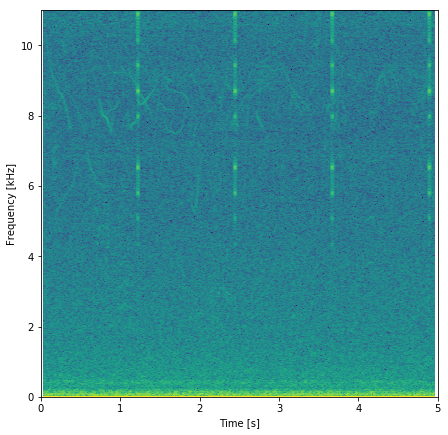

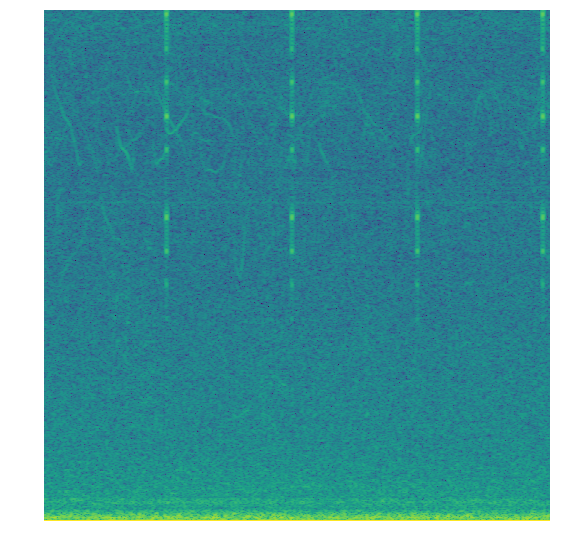

In [24]:
for data_url in data_url_list:
    stream = read(data_url)         # Read from url
    samp_rate = stream[0].stats.sampling_rate
    t_start = stream[0].stats.starttime
    t_end = stream[0].stats.endtime
    duration = t_end-t_start

    # Ping Detections

    pingtimes = np.zeros(int(duration)-1)
    for stratpoint in range(int(duration)-1):
        pingindex = np.argmax(stream[0].data[int(stratpoint * samp_rate):int((stratpoint + 1) * samp_rate)])
        pingtimes[stratpoint] = (t_start + stratpoint + pingindex * stream[0].stats.delta)

    # Filter Data+Plot Spectrogram+Save Image and Audio 

    def _nearest_pow_2(x):

        a = M.pow(2, M.ceil(np.log2(x)))
        b = M.pow(2, M.floor(np.log2(x)))
        if abs(a - x) < abs(b - x):
            return a
        else:
            return b
    step_size = 5 # for calculating the rms pressure and ploting the spectrogtam 
    wlen = 0.056;  # bin size in sec 
    nfft = int(_nearest_pow_2(wlen * samp_rate))  # number of fft points of each bin
    per_lap = 0.995      # percentage of overlap
    nlap = int(nfft * float(per_lap))   # number of overlapped samples

    for i in range(0, len(pingtimes), timestep):
        st = stream.slice(UTCDateTime(pingtimes[i]), UTCDateTime(pingtimes[i]) + step_size)
        trace = st[0].copy()
        # Plot Spectrogram
        npts = len(st[0])
        end = npts / samp_rate
        # using mlab to create the array of spectrogram 
        specgram, freq, time = mlab.specgram(trace.data/1e-6,NFFT = nfft,Fs = samp_rate,noverlap = nlap, pad_to = None)
        specgram = 10 * np.log10(specgram[1:, :])
        specgram = np.flipud(specgram)
        freq = freq[1:] / 1e3  # Convert Frequency to kHz
        halfbin_time = (time[1] - time[0]) / 2.0
        halfbin_freq = (freq[1] - freq[0]) / 2.0
        freq = np.concatenate((freq, [freq[-1] + 2 * halfbin_freq]))
        time = np.concatenate((time, [time[-1] + 2 * halfbin_time]))
        extent = (time[0] - halfbin_time, time[-1] + halfbin_time,
                      freq[0] - halfbin_freq, freq[-1] + halfbin_freq)
        # colormap setting
        vmin = 0.50  # default should be 0 to start from the min number of the spectrgram
        vmax = 0.95  # default should be 1 to end at the max number of the spectrgram
        _range = float(specgram.max() - specgram.min())
        vmin = specgram.min() + vmin * _range
        vmax = specgram.min() + vmax * _range
        norm = Normalize(vmin, vmax)  # to scale a 2-D float X input to the (0, 1) range for input to the cmap

        # plot spectrogram
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, cmap='viridis')
        dpi = fig.get_dpi()
        fig.set_size_inches(512/float(dpi),512/float(dpi))
        ax.axis('tight')
        ax.set_xlim(0, end)
        ax.set_ylim(0,11)
        ax.grid(False)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [kHz]')

        # Save spectrogram
        fig = plt.figure(frameon=False, figsize=(8,8))
        ax = plt.Axes(fig, [0., 0., 1., 1.])
        ax.set_axis_off()
        fig.add_axes(ax)

        cax = ax.imshow(specgram, interpolation="nearest", extent=extent, norm=norm, 
                    cmap='viridis')
        dpi = fig.get_dpi()
        fig.set_size_inches(512/float(dpi),512/float(dpi))
        ax.axis('tight')
        ax.set_xlim(0, end)
        ax.set_ylim(0,11)
        ax.grid(False)
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Frequency [kHz]')
        filename = st[0].stats.network+'_'+st[0].stats.station+'_'+st[0].stats.location+'_'+st[0].stats.channel+'_'+str(UTCDateTime(pingtimes[i])).replace("-","_").replace(":","_")
        fig.savefig(filename + '.jpg')

        #save audio
        def Save2Wav(sound):
            sound = sound.copy()
            sound.normalize()
            sound.data = (sound.data * (2**31-1)).astype('int32')
            sound.write(filename + '.wav', format = 'WAV', framerate = samp_rate)
        Save2Wav(st[0])